# Beamforming - Contre-mesures RADAR
## Direction of Arrival Methods
### Maxime BARRET


Avec l'aide de :
#### 'Signaux et Sytèmes' - Prof. Dr Ir Xavier Neyt 
#### 'Source Localization with sensor arrays' - Assistant Professors Charles Vanwynsberghe & Angélique Drémeau
#### Polarized Uniform Linear Array System: Beam Radiation Pattern, Beamforming Diversity Order, and Channel Capacity, Xin Su and KyungHi Chang

In [2]:
%matplotlib notebook
#Indique qu'on va afficher des figures, et permet de les modifier

import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rd     
from scipy.signal import find_peaks
import time
import warnings
 #Imports d'usage

### Situation initiale

La situation est la suivante : 
- Nous avons un Uniform Linear Array (ULA) sur notre cible décrit ci-après
- Ma source ne bouge pas pour l'instant
- M antennes dans mon array
- d : distance entre mes antennes dans mon array (doit être cohérente avec la taille d'un UGV/UAV)
- Le problème est plan


Avec notre array, on mesure : 

$$ \mathbf{y}_l = \sum_{s=1}^{S} x_s \mathbf{a}(\theta_s)  + \mathbf{n}_l $$ 

Ici, S=3 : trois RADAR éclairent notre cible, du moins pour l'instant

Le diagramme de rayonnement de notre ULA
$DP(\theta) = 20 \log_{10} \left( \dfrac{\mathbf{a}(\theta)^H \mathbf{a}(\theta_0)}{\|\mathbf{a}(\theta)\|^2} \right)$ dB.




### Description de notre ULA

![](ULA.jpg)

### Déclaration de nos variables

En choisissant nos variables, nous devons faire attention à plusieurs choses :
- Rester cohérent avec la réalité : On ne va pas mettre 100000000 de capteurs, ni avoir une fréquence de 2 Hz
- Vérifier la condition d'échantillonnage spatial, ici : $ d < \dfrac{\lambda}{2} ) $

![](Shannon.jpg)

In [3]:
t1 = time.time()
c0 = 3e8   #célérité de la lumière dans l'air 
d = 0.4          #Distance entre mes émetteurs
M = 5              #Nombre d'émetteurs sur ma cible
N = 4*721
angle = np.linspace(-np.pi/2,np.pi/2,N)     #Grille sur laquel on va chercher l'angle d'incidence

theta0 = 0   #Angle d'incidence auquel se situe le radar qu'on doit tromper : là, il est en face de la cible.
lam = 1  #Correspond à une fréquence de 300 Mhz, sachant qu'un radar se situe entre 300Mhz et 15 Ghz
         #Attention, la résolution du beamforming baisse si la fréquence est faible

#A priori, ce sont des paramètres qui ne sont pas amenés à bouger.

In [4]:
from BeamformingMethods import a, compute_A, DP

##  I- Affichage des Diagrammes de Rayonnement de notre ULA avec des sources situées à des angles différents

Il est plus logique d'afficher ces lobes sur une projection polaire, mais la mise en forme laisse à désirer dans cette projection.

<IPython.core.display.Javascript object>


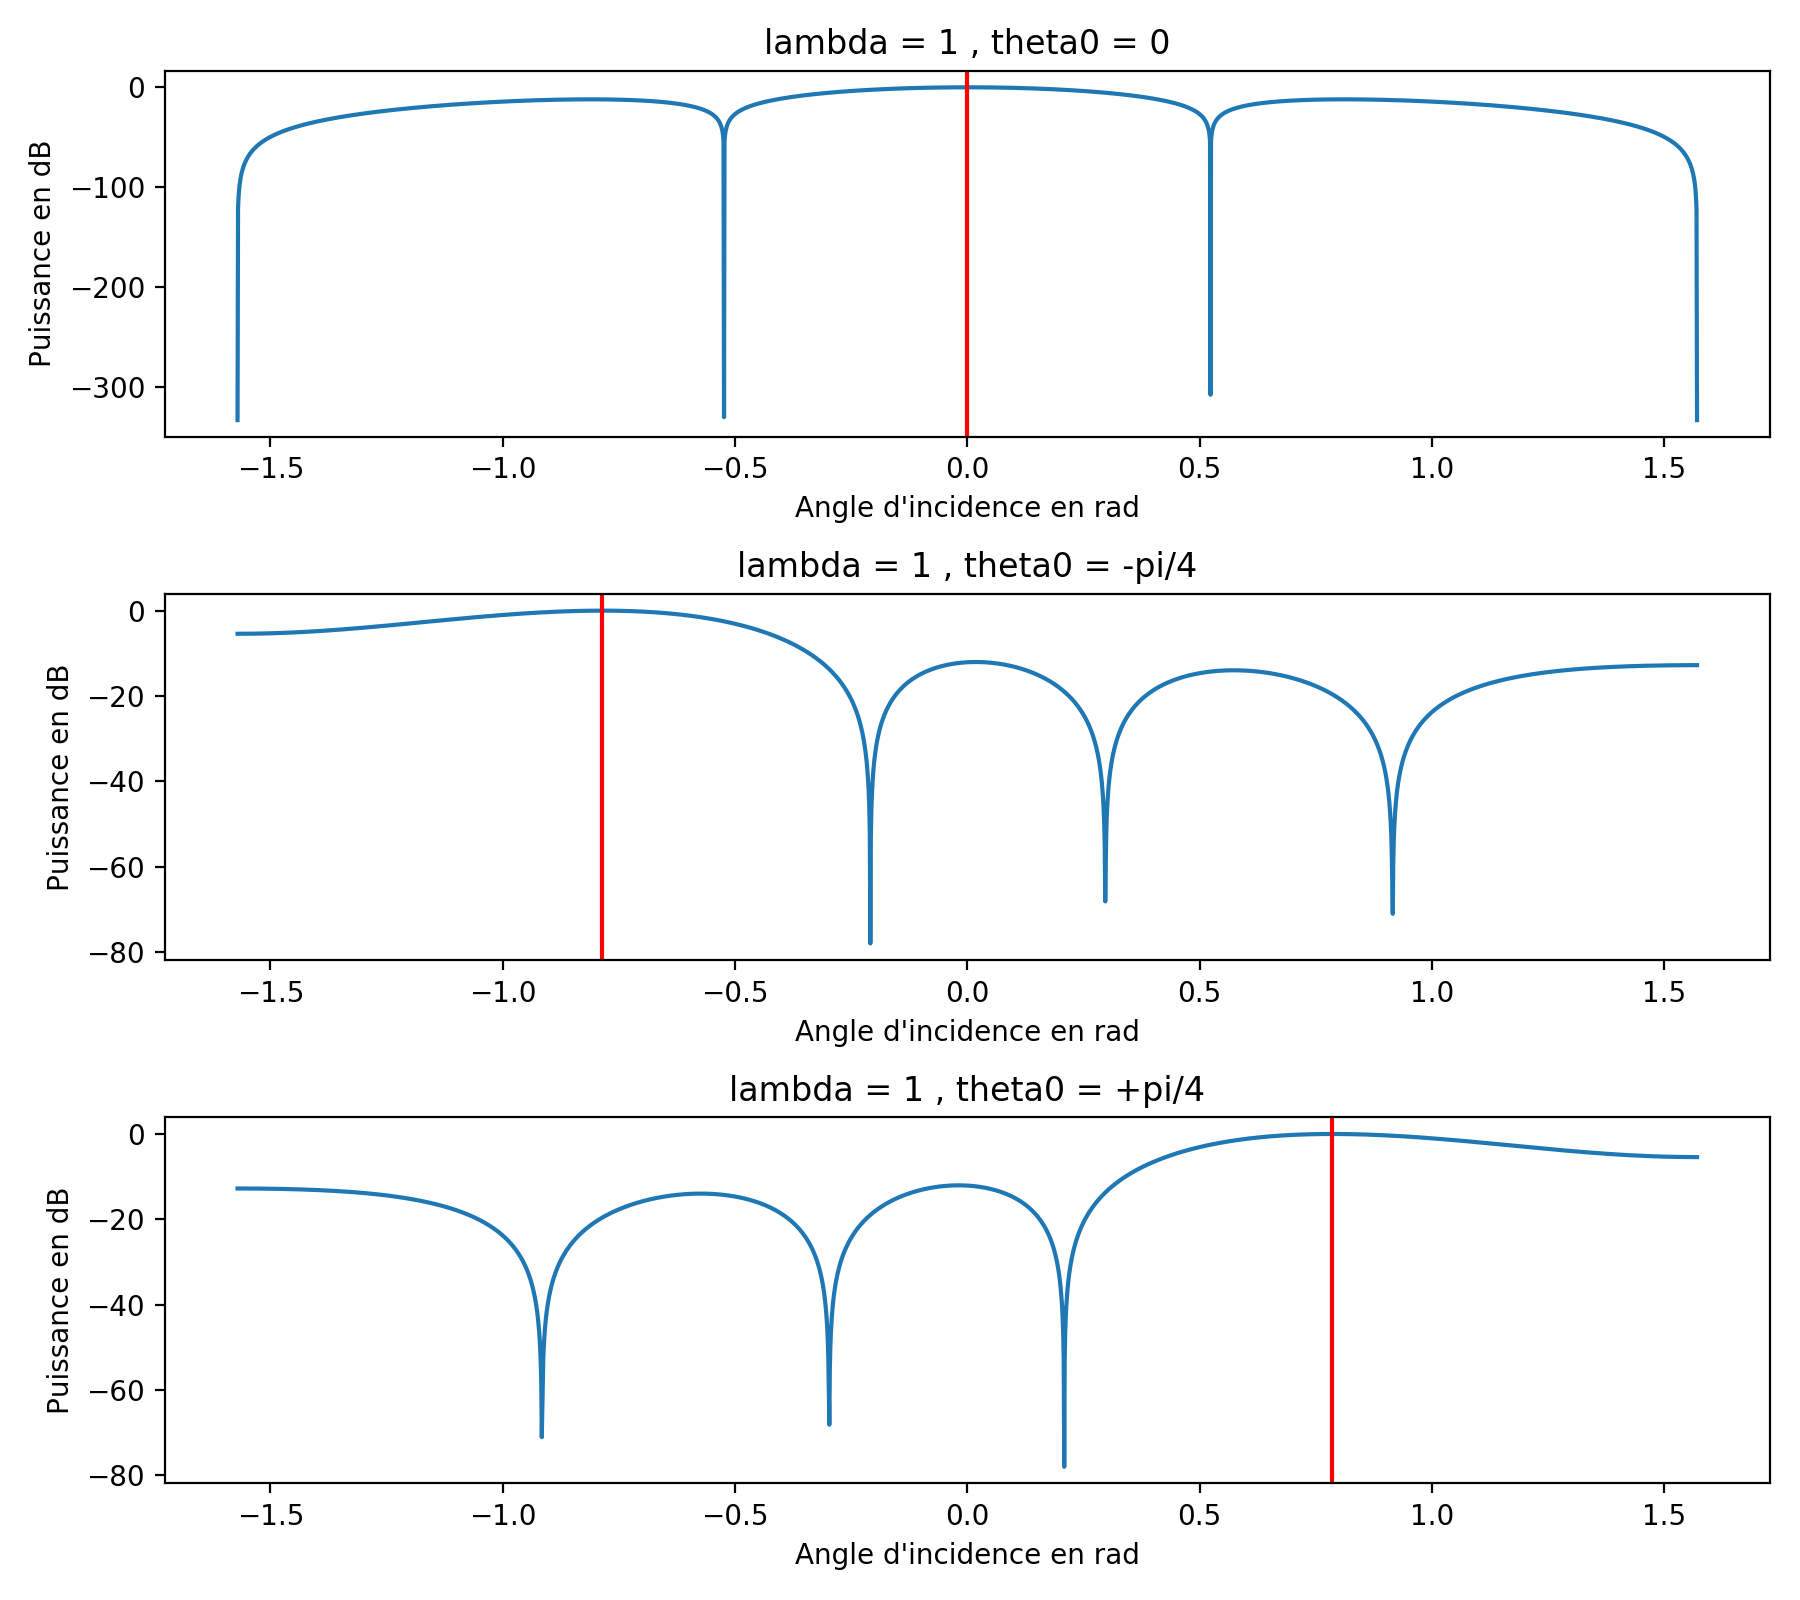

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [5]:
DPs = {}  #Je répertorie mes différents diagramme de rayonnement dans un dict pour y avoir plus facilement accès 


theta0 = 0   #Angle

lam = 1


plt.figure(figsize=(9,8))
plt.subplot(311)
DP01 = []
for i in range(N):
    DP01.append(DP(angle[i],lam,M,theta0))
DPs["0"] = DP01
plt.title("lambda = 1 , theta0 = 0")
plt.xlabel("Angle d'incidence en rad")
plt.ylabel("Puissance en dB")
plt.plot(angle,DP01)
plt.axvline(theta0,color='r')


#Autre source
theta0 = - np.pi/4

plt.subplot(312)
DPpi1 = []
for i in range(N):
    DPpi1.append(DP(angle[i],lam,M,theta0))
DPs["-pi/4"] = DPpi1
plt.title("lambda = 1 , theta0 = -pi/4")
plt.xlabel("Angle d'incidence en rad")
plt.ylabel("Puissance en dB")
plt.plot(angle,DPpi1)
plt.axvline(theta0,color='r')


#Autre source
theta0 = np.pi/4

plt.subplot(313)
DPpi2 = []
for i in range(N):
    DPpi2.append(DP(angle[i],lam,M,theta0))
DPs["pi/4"] = DPpi2
plt.title("lambda = 1 , theta0 = +pi/4")
plt.xlabel("Angle d'incidence en rad")
plt.ylabel("Puissance en dB")
plt.plot(angle,DPpi2)
plt.axvline(theta0,color='r')

plt.tight_layout()
plt.show()



#Je répertorie mes différents diagrammes de rayonnement



## II- Détection de la direction de la source : DoA

Dans l'idée, il faudrait dans un premier temps repérer la (Ou les) sources qui éclairent notre cible, en fonction de ce que mesure notre array dans le temps.
On va vérifier la validité des différentes méthodes en fonction de tous les paramètres, et qui plus est du RSB :
$SNR = \log_{10}\left( \dfrac{\|\mathbf{A} \mathbf{S}_{xx} \mathbf{A}^H\|_F}{\|\mathbf{S}_{nn}\|_F} \right)$

Dans cette partie, nos sources émettrons un même signal, assez lointain pour avoir un front d'onde plat. Je ne considère pas encore que c'est aussi un ULA. 

In [6]:
import scipy.signal

res = {}
#Dans le dictionnaire res, on va stocker tous les résultats de nos détections de sources
s_angles = [-np.pi/3,-np.pi/12,np.pi/3] 
S = len(s_angles)
s_amp = [1,1,1]   #Amplitude du signal reçu, venant de chaque source
lam = 1
L = 64  #Nombre de mesures effectuées par notre array.
sig_n = 1e-1  #Ecart-type de notre bruit, que je vais considérer Gaussien et additif



# C'est ici que je dois prendre en compte que mes sources sont cohérentes !!! 
##################################################################

temp1 = scipy.signal.square(4*np.pi*c0*np.linspace(0,L,L)/lam)
temp2 = scipy.signal.square(4*np.pi*c0*np.linspace(1,L+1,L)/lam)
temp3 =  scipy.signal.square(4*np.pi*c0*np.linspace(2,L+2,L)/lam)

s = np.array([temp1,temp2,temp3])

##################################################################
n = sig_n*(rd.randn(M,L)) / (2**0.5) #Gaussien centré

for i in range(len(s_amp)):
    s[i] *= s_amp[i]

    A = compute_A(s_angles,lam,M)
y = A@s + n     #On retrouve bien la linéarité


snr = np.log10(np.linalg.norm(A @ s @ (A @ s).T.conj())/np.linalg.norm(n@ n.T.conj()))
print(f"Le RSB est de {snr} dB")


print(f"Notre vecteur y est de dimension {y.shape}, et chaque ligne représente l'acquisition d'un des capteur de l'array")


#Calcul de la matrice de covariance des y
Syy = y @ y.T.conj() / L

print(s.shape)
print(A.shape)


Le RSB est de 3.1981107845057912 dB
Notre vecteur y est de dimension (5, 64), et chaque ligne représente l'acquisition d'un des capteur de l'array
(3, 64)
(5, 3)


### Première méthode : Classical Beamforming

Avec le classical beamforming (CBF), la puissance est donnée par : 
$$ P_{\text{CBF}}(\theta) =  \dfrac{\mathbf{a}(\theta)^H \mathbf{S}_{yy} \mathbf{a}(\theta)}{\|\mathbf{a}(\theta)\|^4} $$

In [7]:
##################### CBF ##############################
angles1 = np.linspace(- np.pi/2,np.pi/2,N)
PCBF = np.zeros(N, dtype = complex)   #Ça signifie Puissance pour du classic beamforming 
                                        # Un pic de puissance indiquera la position de notre source

for i in range(N):
    a_pcbf = a(angles1[i], lam,M)
    PCBF[i] = a_pcbf.T.conj() @ Syy @ a_pcbf / (np.linalg.norm(a_pcbf) ** 4)

res["PCBF"]=PCBF/np.max(PCBF)

### MVDR - Minimum Variance Distortionless Response

Avec la méthode MVDR (ou Capon), la puissance est donnée par : 
$$ P_{\text{MVDR}}(\theta) =  \dfrac{1}{\mathbf{a}(\theta)^H \mathbf{S}_{yy}^{-1} \mathbf{a}(\theta)} $$

In [8]:
##################### MVDR ##############################
PMVDR = np.zeros(N, dtype = complex)
for i in range(N):
    a_pmvdr = a(angle[i], lam,M)
    PMVDR[i] = 1/(np.conj(a_pmvdr.T) @ np.linalg.inv(Syy) @ a_pmvdr)
    
res["MVDR"]=PMVDR

### MUSIC - Singular values decomposition


$$ P_{\text{MUSIC}}(\theta) =  \dfrac{1}{\mathbf{a}(\theta)^H \mathbf{U}_{n} \mathbf{U}_{n}^H \mathbf{a}(\theta)} $$




In [9]:
##################### MUSIC ##############################

#Principe : Décomposer notre Syy en valeurs singulières
eig = np.linalg.eig(Syy)    #On calcule les valeurs propres et des vecteurs propres de la matrice de covariance
eigvals = eig[0]
Diagonale = np.diag(eigvals)   

U = eig[1]
#Où commence le sous-espace contenant le bruit? à S+1 !
Unoise = U[:,S:]

PMUSIC= np.zeros(N, dtype = complex)
for i in range(N):
    a_music = a(angle[i], lam,M)
    PMUSIC[i] = 1 / (np.conj(a_music).T @ Unoise@np.conj(Unoise.T)@a_music)
    
res["MUSIC"] = PMUSIC



### Affichages des véritables directions de nos sources, et des différentes méthodes de détection

Selon CBF, on trouve les directions suivantes : [-1.15671197 -0.24463668  1.14036653]
Selon MUSIC, on trouve les directions suivantes : [-1.05428057 -0.26098212  1.04229392]
Selon MVDR, on trouve les directions suivantes : [-1.05754966 -0.25989242  1.04338362]


<IPython.core.display.Javascript object>


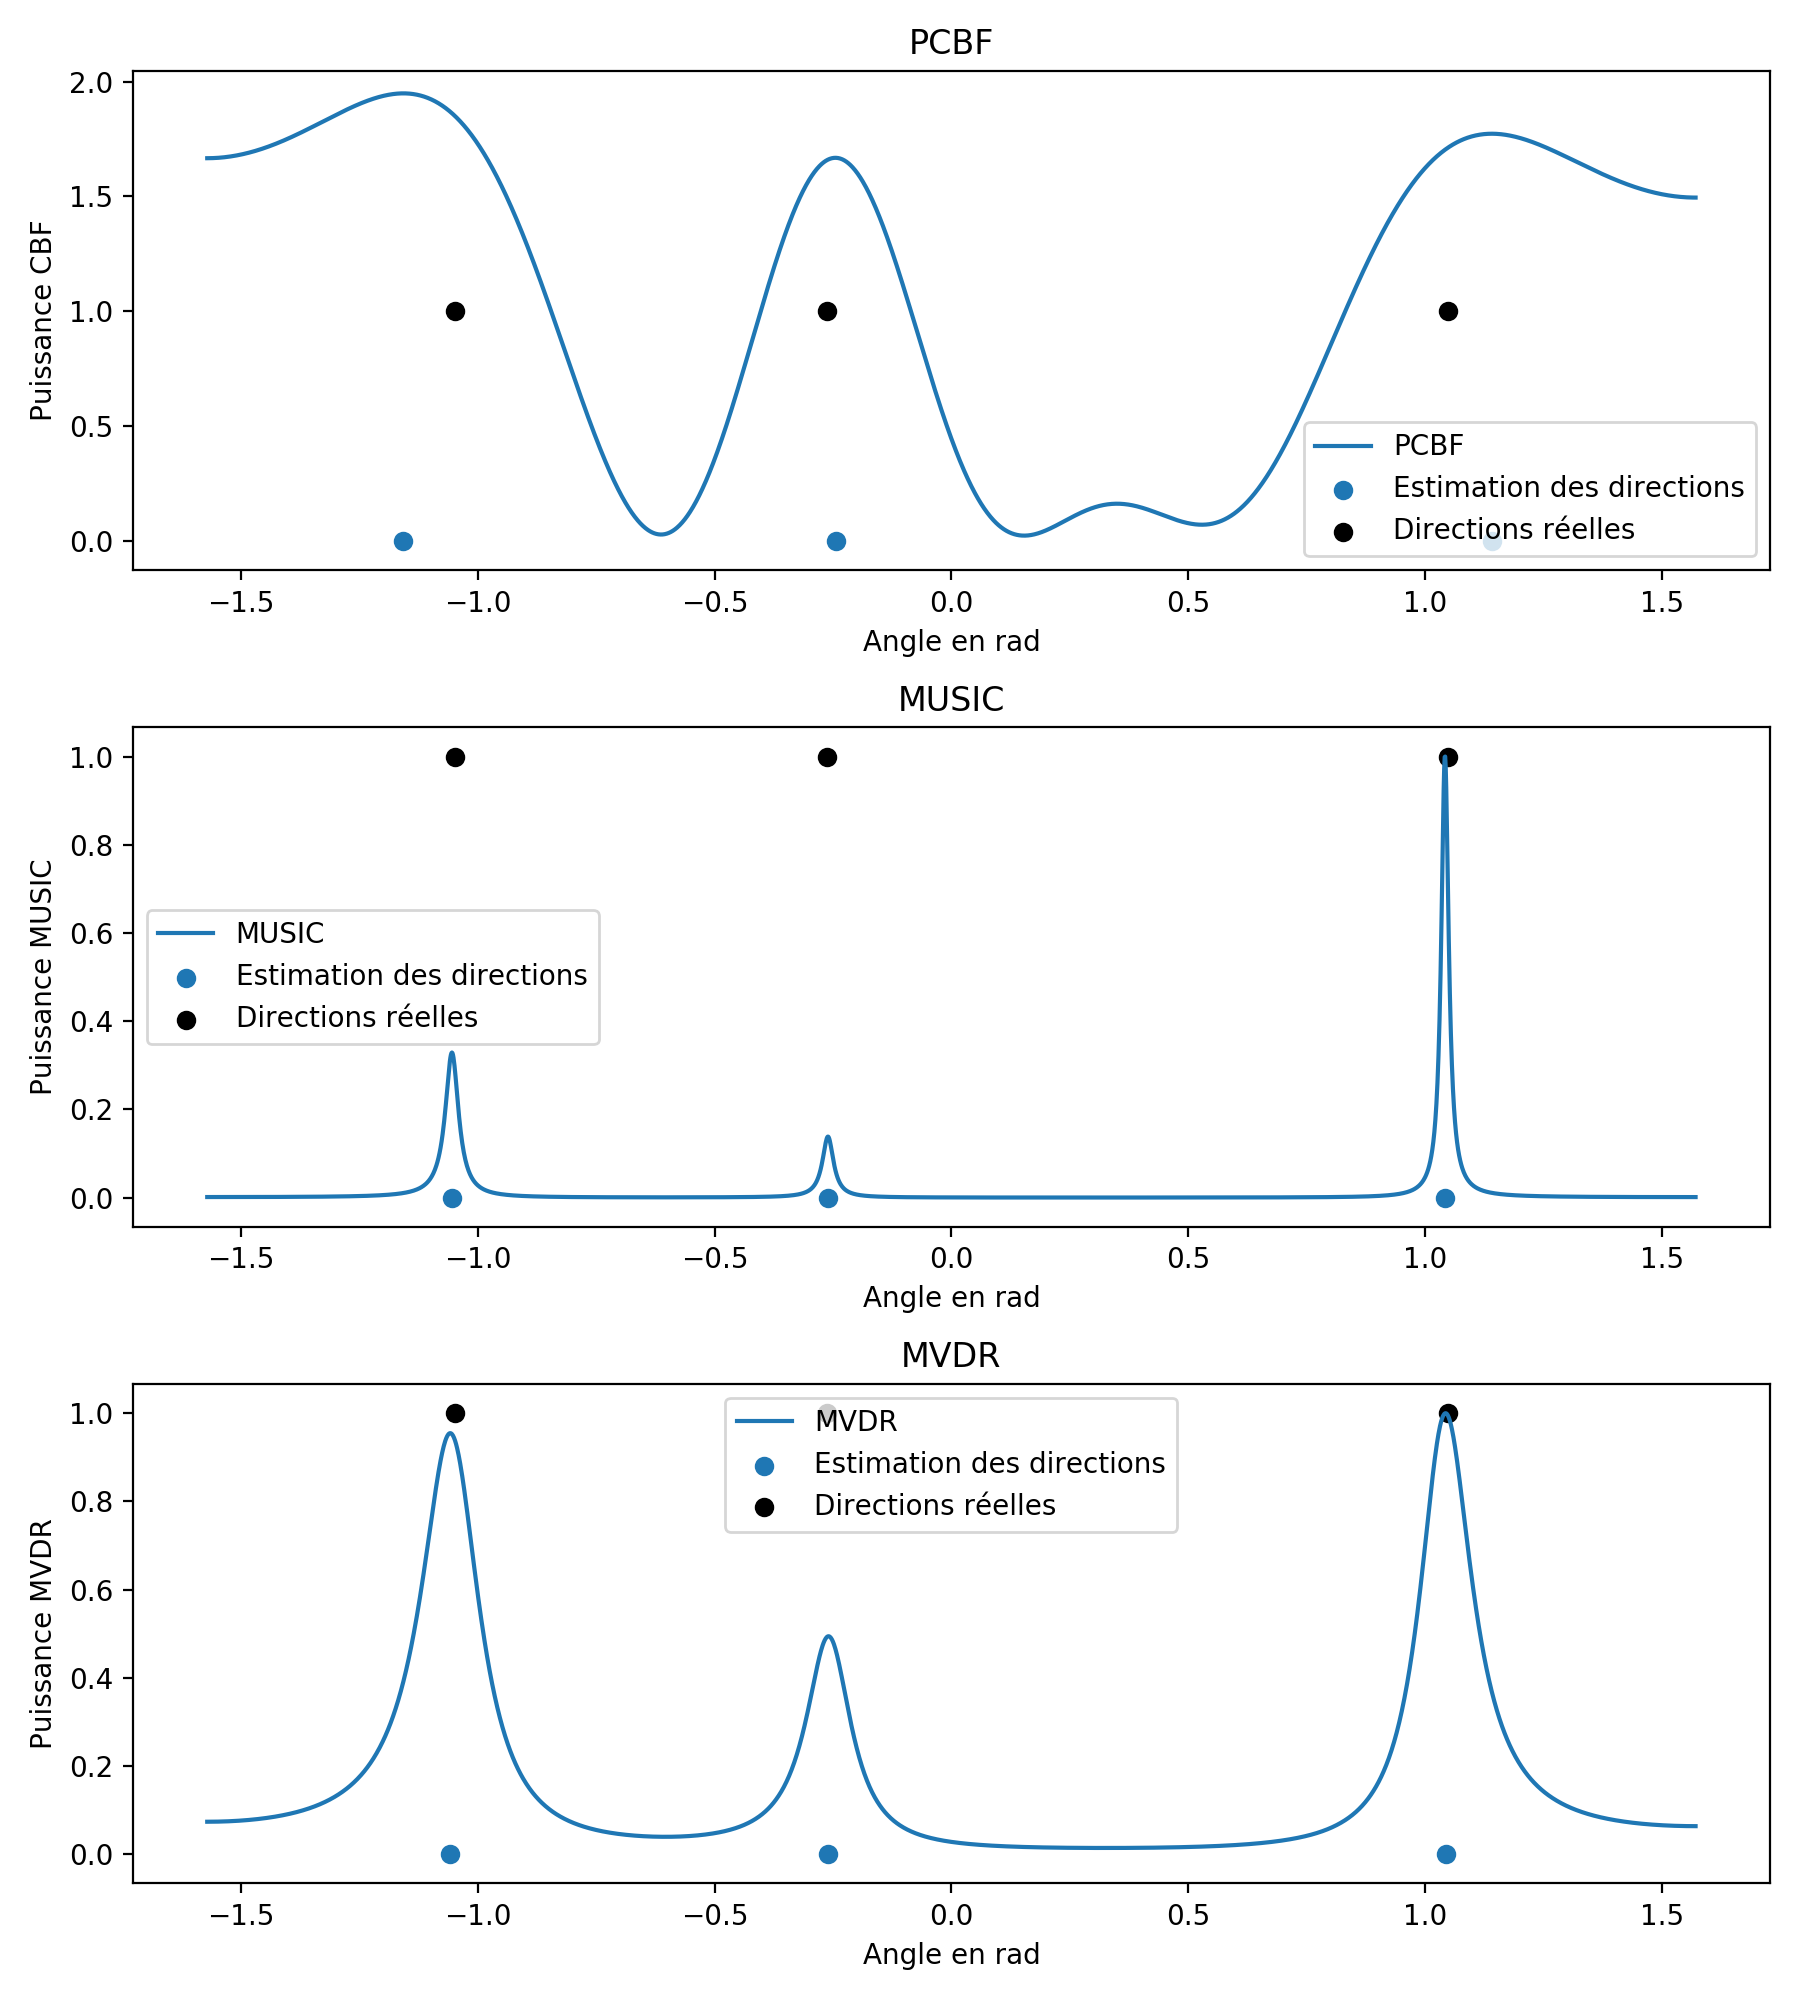

Temps de calcul pour 5 capteurs, avec 2884 possibles d'angles valeurs  : 25.688616037368774


In [10]:
#On recherche les maxima de puissance : 
peakind1 = find_peaks(PCBF,prominence=0.1)
peakind2 = find_peaks(PMUSIC,threshold=0)
peakind3 = find_peaks(PMVDR,threshold=0)

#nombre de directions détectées
k1,k2,k3 = len(peakind1[0]),len(peakind2[0]),len(peakind3[0])


print(f"Selon CBF, on trouve les directions suivantes : {angle[peakind1[0]]}")
print(f"Selon MUSIC, on trouve les directions suivantes : {angle[peakind2[0]]}")
print(f"Selon MVDR, on trouve les directions suivantes : {angle[peakind3[0]]}")
    
plt.figure(figsize=(9,10))

plt.subplot(311)
plt.title("PCBF")
plt.xlabel("Angle en rad")
plt.ylabel("Puissance CBF")
plt.plot(angle, PCBF,label='PCBF')

if len(angle[peakind1[0]]) < len(s_angles):
    print("SOURCE(S) NON DETECTEE(S) par PCBF")
    plt.scatter(angle[peakind1[0]],k1*[0],label='Estimation des directions')
elif len(angle[peakind1[0]]) > len(s_angles) : 
    print("Faux-positif(s) par PCBF")
    plt.scatter(angle[peakind1[0]],k1*[0],label='Estimation des directions')
else:
    plt.scatter(angle[peakind1[0]],S*[0],label='Estimation des directions')
plt.scatter(s_angles, s_amp, color='k',label='Directions réelles')
plt.legend()

plt.subplot(312)
plt.title("MUSIC")
plt.plot(angle, PMUSIC/np.max(PMUSIC),label='MUSIC')
plt.xlabel("Angle en rad")
plt.ylabel("Puissance MUSIC")
if len(angle[peakind2[0]]) < len(s_angles):
    print("SOURCE(S) NON DETECTEE(S) par MUSIC")
    plt.scatter(angle[peakind2[0]],k2*[0],label='Estimation des directions')
elif len(angle[peakind2[0]]) > len(s_angles) : 
    print("Faux-positif(s) par MUSIC")
    plt.scatter(angle[peakind2[0]],k2*[0],label='Estimation des directions')
else: 
    plt.scatter(angle[peakind2[0]],S*[0],label='Estimation des directions')
plt.scatter(s_angles, s_amp, color='k',label='Directions réelles')
plt.legend()

plt.subplot(313)
plt.title("MVDR")
plt.plot(angle, PMVDR/np.max(PMVDR),label='MVDR')
plt.xlabel("Angle en rad")
plt.ylabel("Puissance MVDR")
if len(angle[peakind3[0]]) < len(s_angles):
    print("SOURCE(S) NON DETECTEE(S) par MVDR")
    plt.scatter(angle[peakind3[0]],k3*[0],label='Estimation des directions')
elif len(angle[peakind3[0]]) > len(s_angles) : 
    print("Faux-positif(s) par MVDR")
    plt.scatter(angle[peakind3[0]],k3*[0],label='Estimation des directions')
else: 
    plt.scatter(angle[peakind3[0]],S*[0],label='Estimation des directions')
plt.scatter(s_angles, s_amp, color='k',label='Directions réelles')
plt.legend()


plt.tight_layout()
plt.show()

t2 = time.time()
duration = t2-t1
print(f"Temps de calcul pour {M} capteurs, avec {N} possibles d'angles valeurs  : {duration}")

#### Comparaison des performances

$ err = \dfrac{| \theta_(estimé) - \theta |}{\theta} ) $

In [19]:
err = {}
for key in res.keys():
    print(f"###### {key} ######")
    if key == "PCBF":
        temp = find_peaks(res[key],prominence=0.1)[0]
    else:
        temp = find_peaks(res[key],threshold=0)[0]
    err_temp = []
    k = len(s_angles)
    for i in range(0,len(temp)):
        if len(temp) != k:
            continue
        if s_angles[i]!=0:
            err_temp.append(100*np.abs((angle[temp[i]]-s_angles[i])/s_angles[i]))
        else:
            err_temp.append(100*np.abs(angle[temp[i]]))
        print(f"l'erreur pour la source {i} est de {round(err_temp[i],4)} %")
    err[key] = err_temp
    print("--------------------")
    print("\n")


###### PCBF ######
l'erreur pour la source 0 est de 10.4579 %
l'erreur pour la source 1 est de 6.5557 %
l'erreur pour la source 2 est de 8.897 %
--------------------


###### MVDR ######
l'erreur pour la source 0 est de 0.9886 %
l'erreur pour la source 1 est de 0.7284 %
l'erreur pour la source 2 est de 0.3642 %
--------------------


###### MUSIC ######
l'erreur pour la source 0 est de 0.6764 %
l'erreur pour la source 1 est de 0.3122 %
l'erreur pour la source 2 est de 0.4683 %
--------------------




<IPython.core.display.Javascript object>


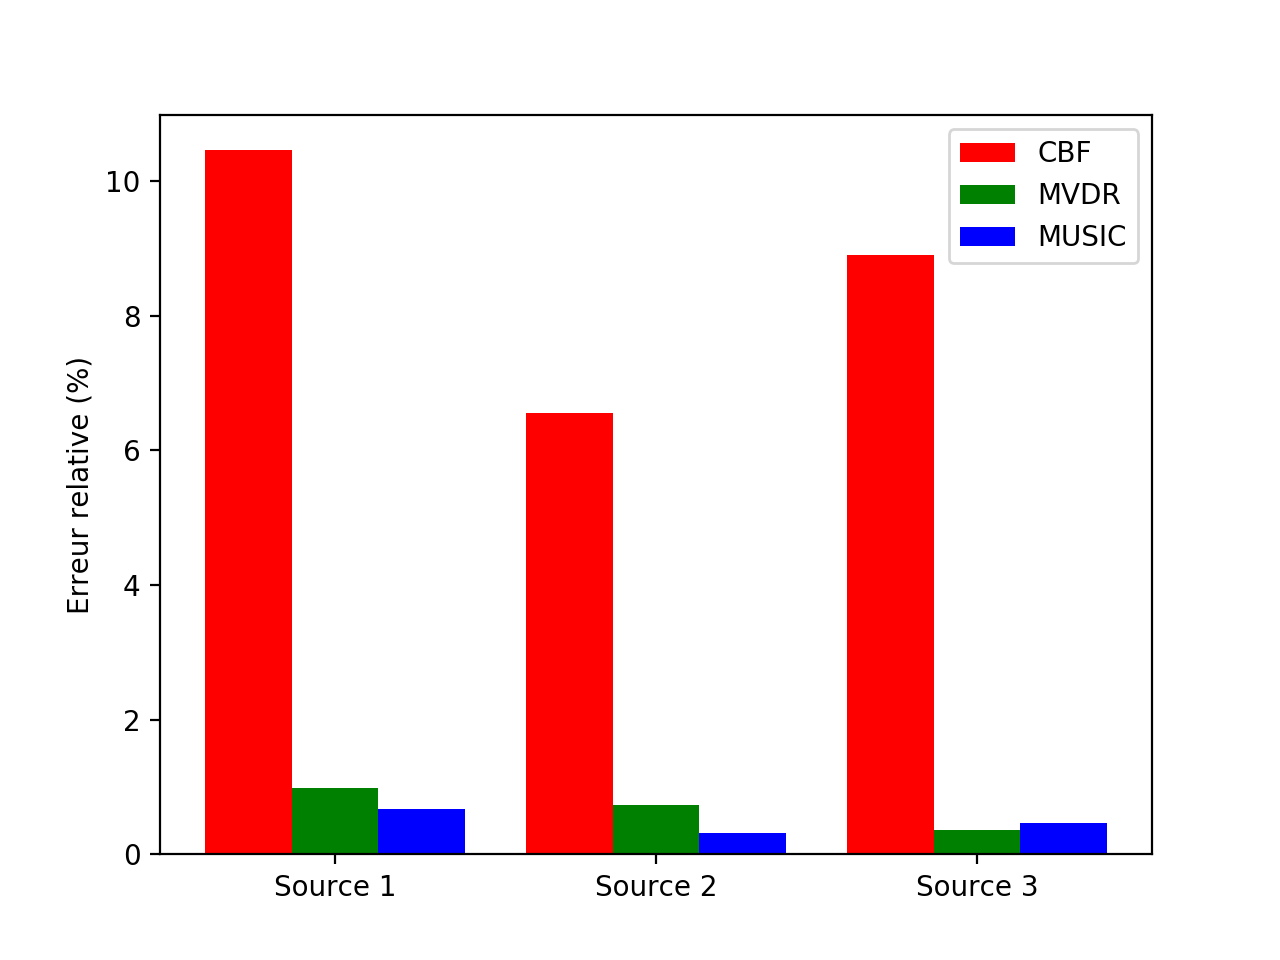

In [34]:
ind = np.arange(3)  
width = 0.27    

fig = plt.figure()
ax = fig.add_subplot(111)

rects1 = ax.bar(ind, err["PCBF"], width, color='r')
rects2 = ax.bar(ind+width, err["MVDR"], width, color='g')
rects3 = ax.bar(ind+width*2, err["MUSIC"], width, color='b')

    
ax.set_ylabel('Erreur relative (%)')
ax.set_xticks(ind+width)
ax.set_xticklabels( ('Source 1', 'Source 2', 'Source 3') )
ax.legend( (rects1[0], rects2[0], rects3[0]), ('CBF', 'MVDR', 'MUSIC') )



plt.show()

#Là, on voit que les 3 algos arrivent à repérer sans trop d'erreur une source relativement isolée.

## III- Cible en mouvement 

Il faut maintenant intégrer le fait que notre UAV/UGV soit en mouvement. Ou bien, si on se place dans le référentiel de l'UAV, les sources bougent. 
Je viens de me rendre compte que ce que je fais ne donne que des directions, et pas les distances... Mais est-ce si grave ?


#### Externalisation des fonctions

In [13]:
from BeamformingMethods import CBF, MUSIC, MVDR
test = CBF(s_angles,s_amp,sig_n,N,M,S,L,lam,[0,0,0])    
test2 = MUSIC(s_angles,s_amp,sig_n,N,M,S,L,lam,[0,0,0])
test3 = MVDR(s_angles,s_amp,sig_n,N,M,S,L,lam,[0,0,0])   #Je vérifie juste que je peux appliquer mes méthodes codées
                                                 #dans un .py à côté.
    # le [0,0,0] correspond au vecteur vitesse de ma cible, je suppose un vitesse constante pour simplifier les calculs
    # J'anticipe donc le fait que ma cible bouge :) 

In [14]:
#  À décommenter pour afficher vérifier que les fonctions fonctionnent bien
#plt.figure()
#plt.title("Mes fonctions fonctionnent-elles?")
#plt.plot(test,label="CBF")
#plt.plot(test2,label="MUSIC")
#plt.plot(test3,label="MVDR")
#plt.legend()
#plt.show()


## Comment s'y prendre pour simuler le mouvement? 
Dans l'idée, je vais créer une matrice S* 'nombre de mesures', représentant les positions angulaires des sources.
A chaque colonne, ou ligne, de cette matrice, je vais appliquer mes méthodes de détection, et voir si je suis bien les sources. Attention, il faut que je modifie mon signal en conséquence (que je feigne un doppler) pour bien simuler un mouvement défini au préalable.

Le mouvement est uniforme, parallèle aux capteurs de notre ULA, et nos sources seront fixes.

![](angle.jpg)

In [15]:
def S_matrix(nbSources,AmpSources,init_pos,v0,T):
    """
    Cette fonction va génerer deux matrices : une dont les lignes sont les s_angles précédents, l'autre dont les 
    lignes sont les s_amp précédents.
    init_pos est sous la forme : 
    [[x1,..,xn],[y1,...,yn]] --> rs = (xs-x)**2  + (ys-y)**2 et thetas = arctan((x1-v0*t)/(y1-y0))
    v0 : vitesse
    T : nombres de fois où on fait appel aux fonctions CBF, MUSIC et MVDR
    """
    if len(init_pos[0]) != nbSources:
        warnings.warn(f' {len(init_pos[0])} is different from {nbSources}')
    S_ang_mat = np.zeros((T,nbSources))
    S_amp_mat = np.zeros((T,nbSources))
    xs = init_pos[0]
    ys = init_pos[1]
    
    for s in range(nbSources):
        x,y = init_pos[0][s],init_pos[1][s]
        S_ang_mat[0][s] = np.arctan(x/y)
        S_amp_mat[0][s] = AmpSources[s] *(x**2 + y**2)**(1/2)
        
    for t in range(1,T):
        for s in range(nbSources):
            S_ang_mat[t][s] = np.arctan((xs[s]-v0*t)/ys[s])
            S_amp_mat[t][s] = AmpSources[s]* ((xs[s]-v0*t)**2 + ys[s]**2)**(1/2)
    
    return np.array(S_amp_mat), np.array(S_ang_mat)


<IPython.core.display.Javascript object>


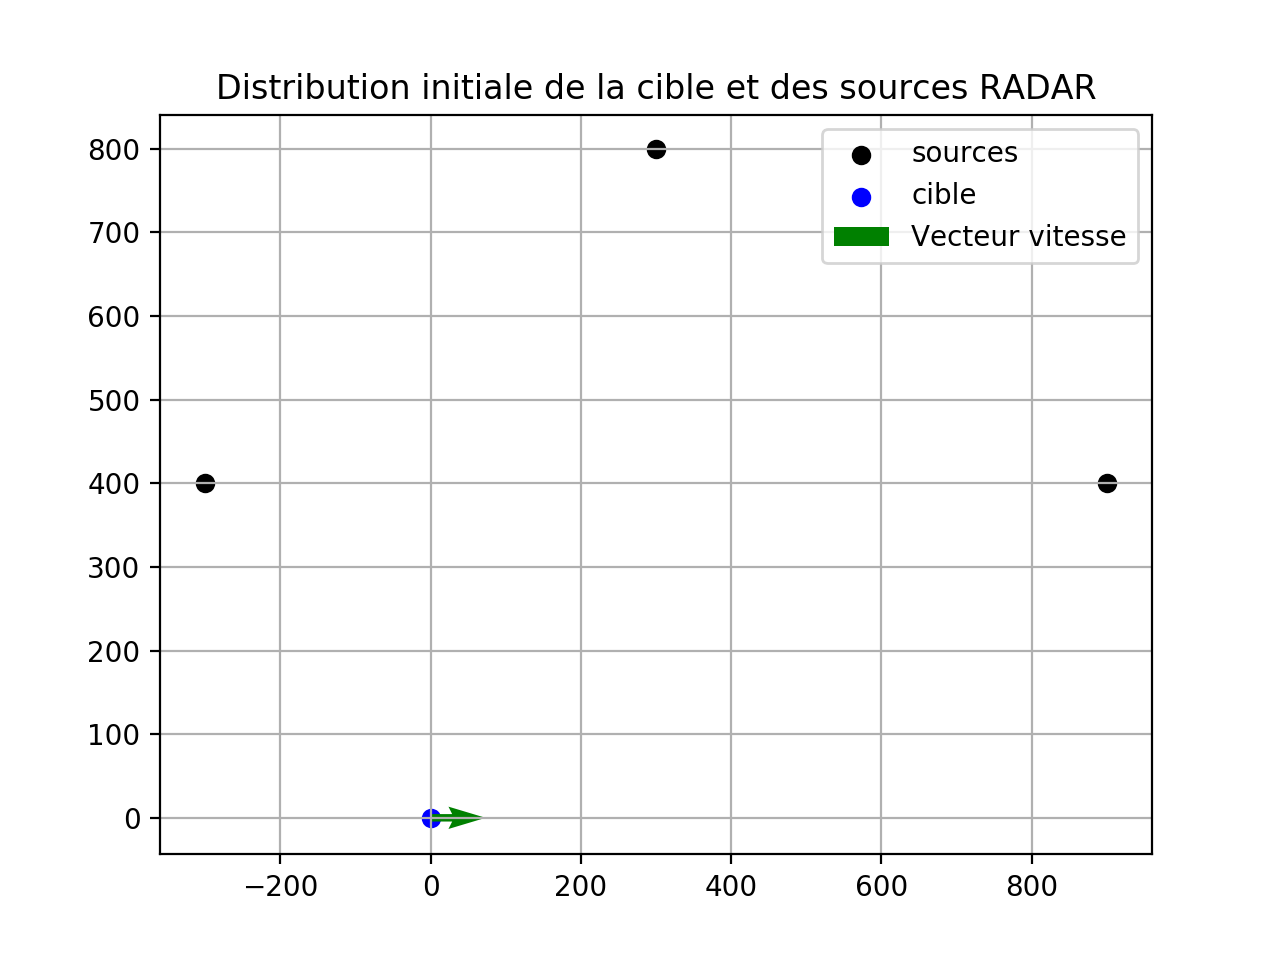

In [16]:
source_pos = [[-300,300,900],[400,800,400]]
Ampsources = [1,1,1]
nbSources = 3
v0 = 50.01
nbIter = 50
S_amp_mat, S_ang_mat = S_matrix(nbSources,Ampsources,source_pos,v0,nbIter)

#Illustration de la disposition initiale

plt.figure()
plt.title("Distribution initiale de la cible et des sources RADAR")
plt.scatter(source_pos[0],source_pos[1],color='k',label='sources')
plt.scatter(0,0,color='b',label='cible')
plt.quiver(0,0,v0,0,color='g',label='Vecteur vitesse')
plt.grid()
plt.legend()
plt.show()


In [17]:

Mouv1 = []
Mouv2 = []
Mouv3 = []
Peaks1 = []
Peaks2 = []
Peaks3 = []

# Attention, gourmand en ressources !!
# On va générer six listes pour chaque itération au cours du temps
# 3 listes pour appliquer les méthodes de beamforming
#
# 3 listes pour les find_peaks

for t in range(nbIter):
    Mouv1.append(CBF(S_ang_mat[t],S_amp_mat[t],sig_n,N,M,S,L,lam,[v0,0,0]))
    
    Mouv2.append(MUSIC(S_ang_mat[t],S_amp_mat[t],sig_n,N,M,S,L,lam,[v0,0,0]))
    
    Mouv3.append(MVDR(S_ang_mat[t],S_amp_mat[t],sig_n,N,M,S,L,lam,[v0,0,0]))

    
    

In [18]:
#On garde en mémoire les directions détectées, pour pouvoir les afficher.
#C'est plus parlant que les courbes, surtout dans le cas du CBF

for t in range(50):
    Peaks1.append(angle[find_peaks(Mouv1[t],threshold=0)[0]])

    Peaks2.append(angle[find_peaks(Mouv2[t],threshold=0)[0]])
    
    Peaks3.append(angle[find_peaks(Mouv3[t],threshold=0)[0]])
    


On vérifie quelle tête ont nos angles. 

<IPython.core.display.Javascript object>


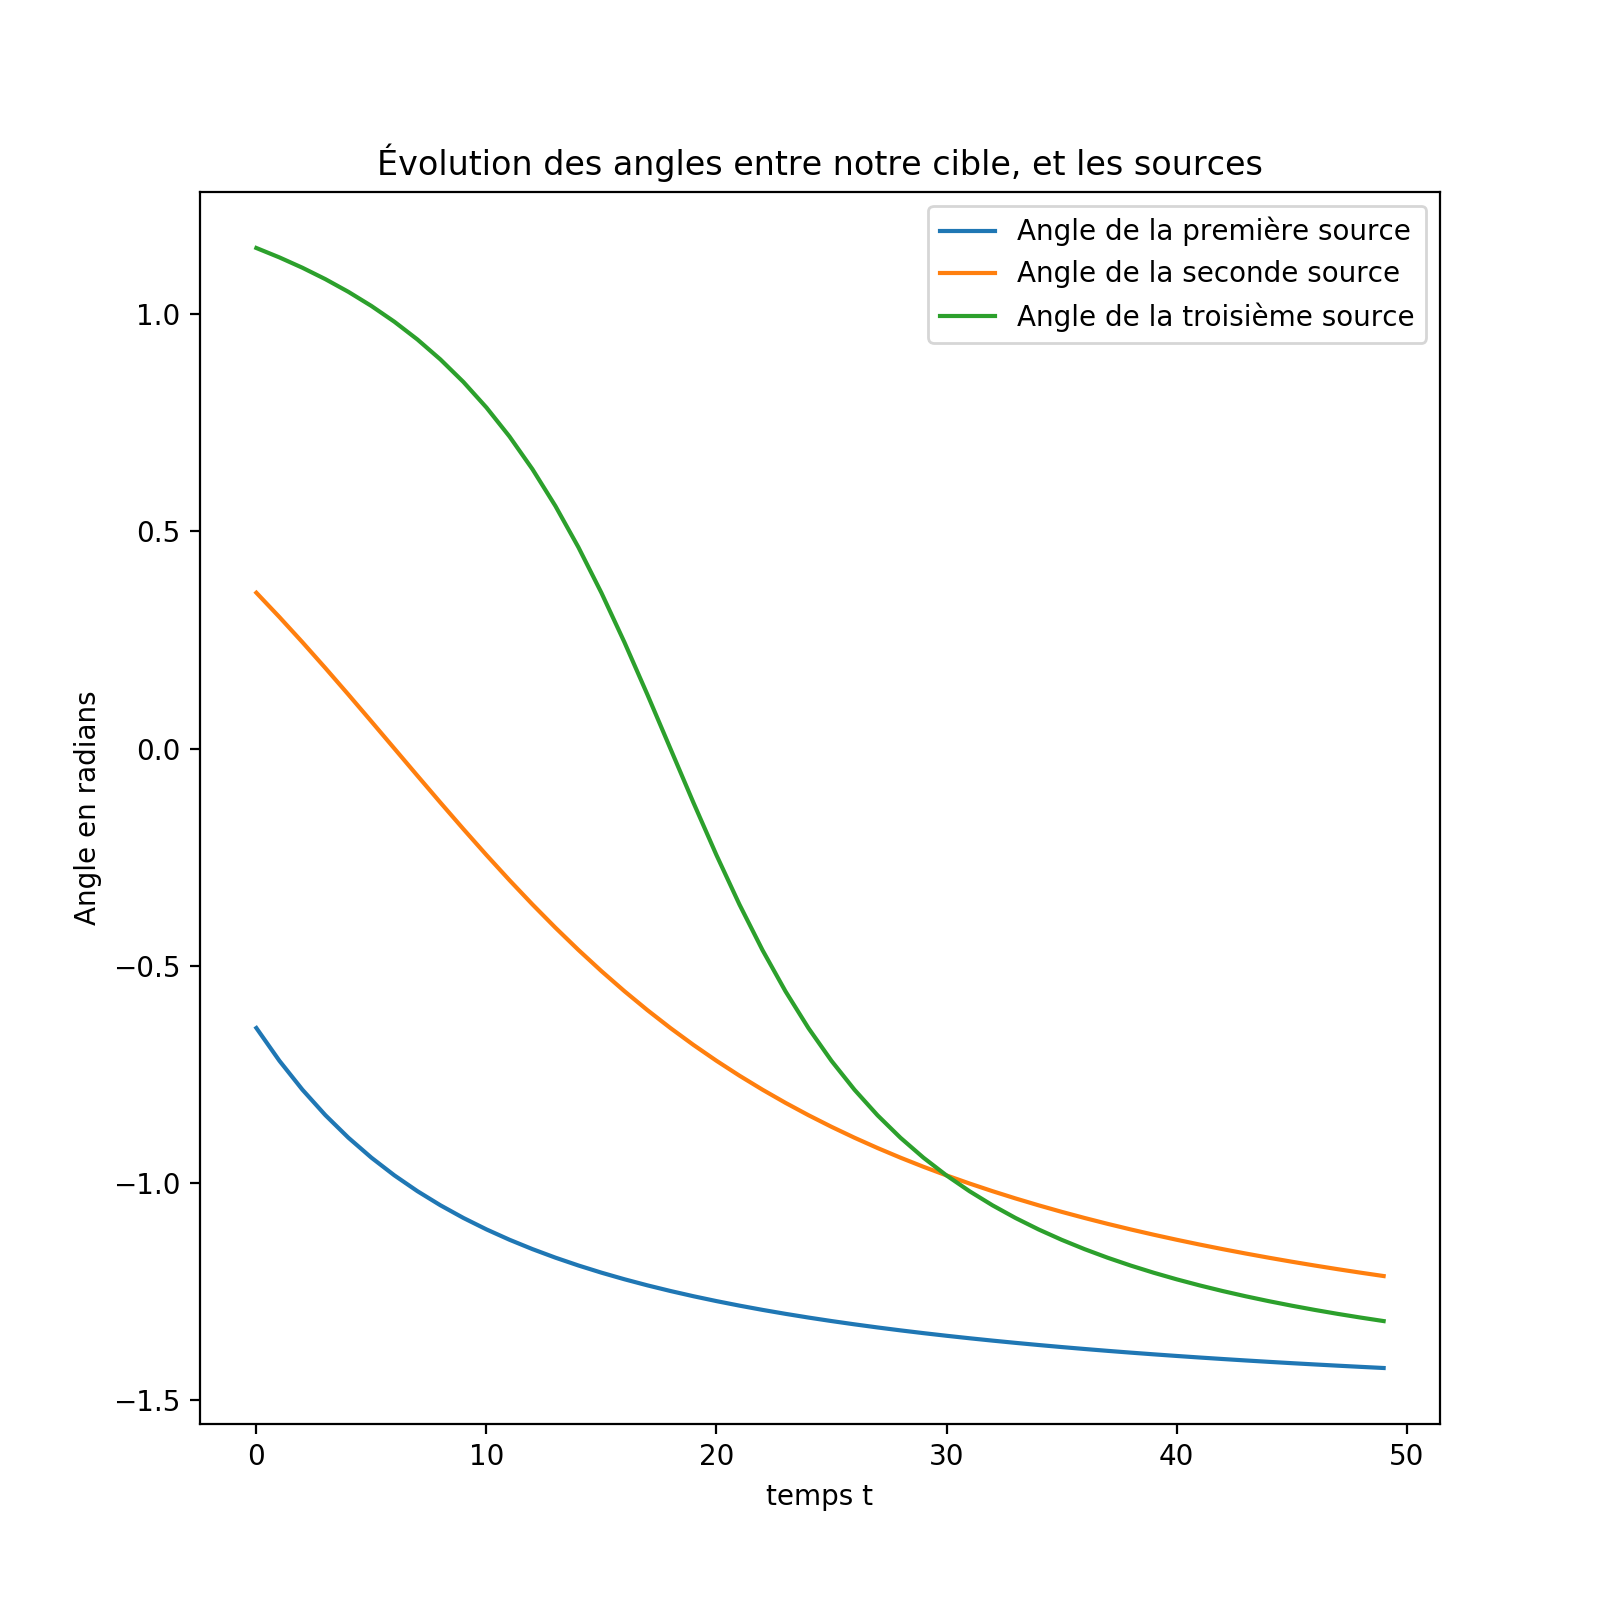

In [19]:
plt.figure(figsize=(8,8))
plt.title("Évolution des angles entre notre cible, et les sources")
plt.xlabel("temps t")
plt.ylabel("Angle en radians")
plt.plot(np.arange(50),S_ang_mat[:,0],label='Angle de la première source')

plt.plot(np.arange(50),S_ang_mat[:,1],label='Angle de la seconde source')

plt.plot(np.arange(50),S_ang_mat[:,2],label='Angle de la troisième source')

plt.legend()
plt.show()

#### Ces angles n'ont pas été choisis par hasard. Ils font en sorte de constater les forces et les faiblesses de chaque méthode selon la situation : 
- Sources bien séparées spatialement
- Cible dans l'alignement de deux sources
- Plusieurs sources à des gisements très proches.

##  IV- Animation des plots
### Attention, consomme beaucoup de ressources CPU !!! Ne pas hésiter à appuyer sur "Stop interaction" quand on a vu les courbes.
#### CBF

<IPython.core.display.Javascript object>


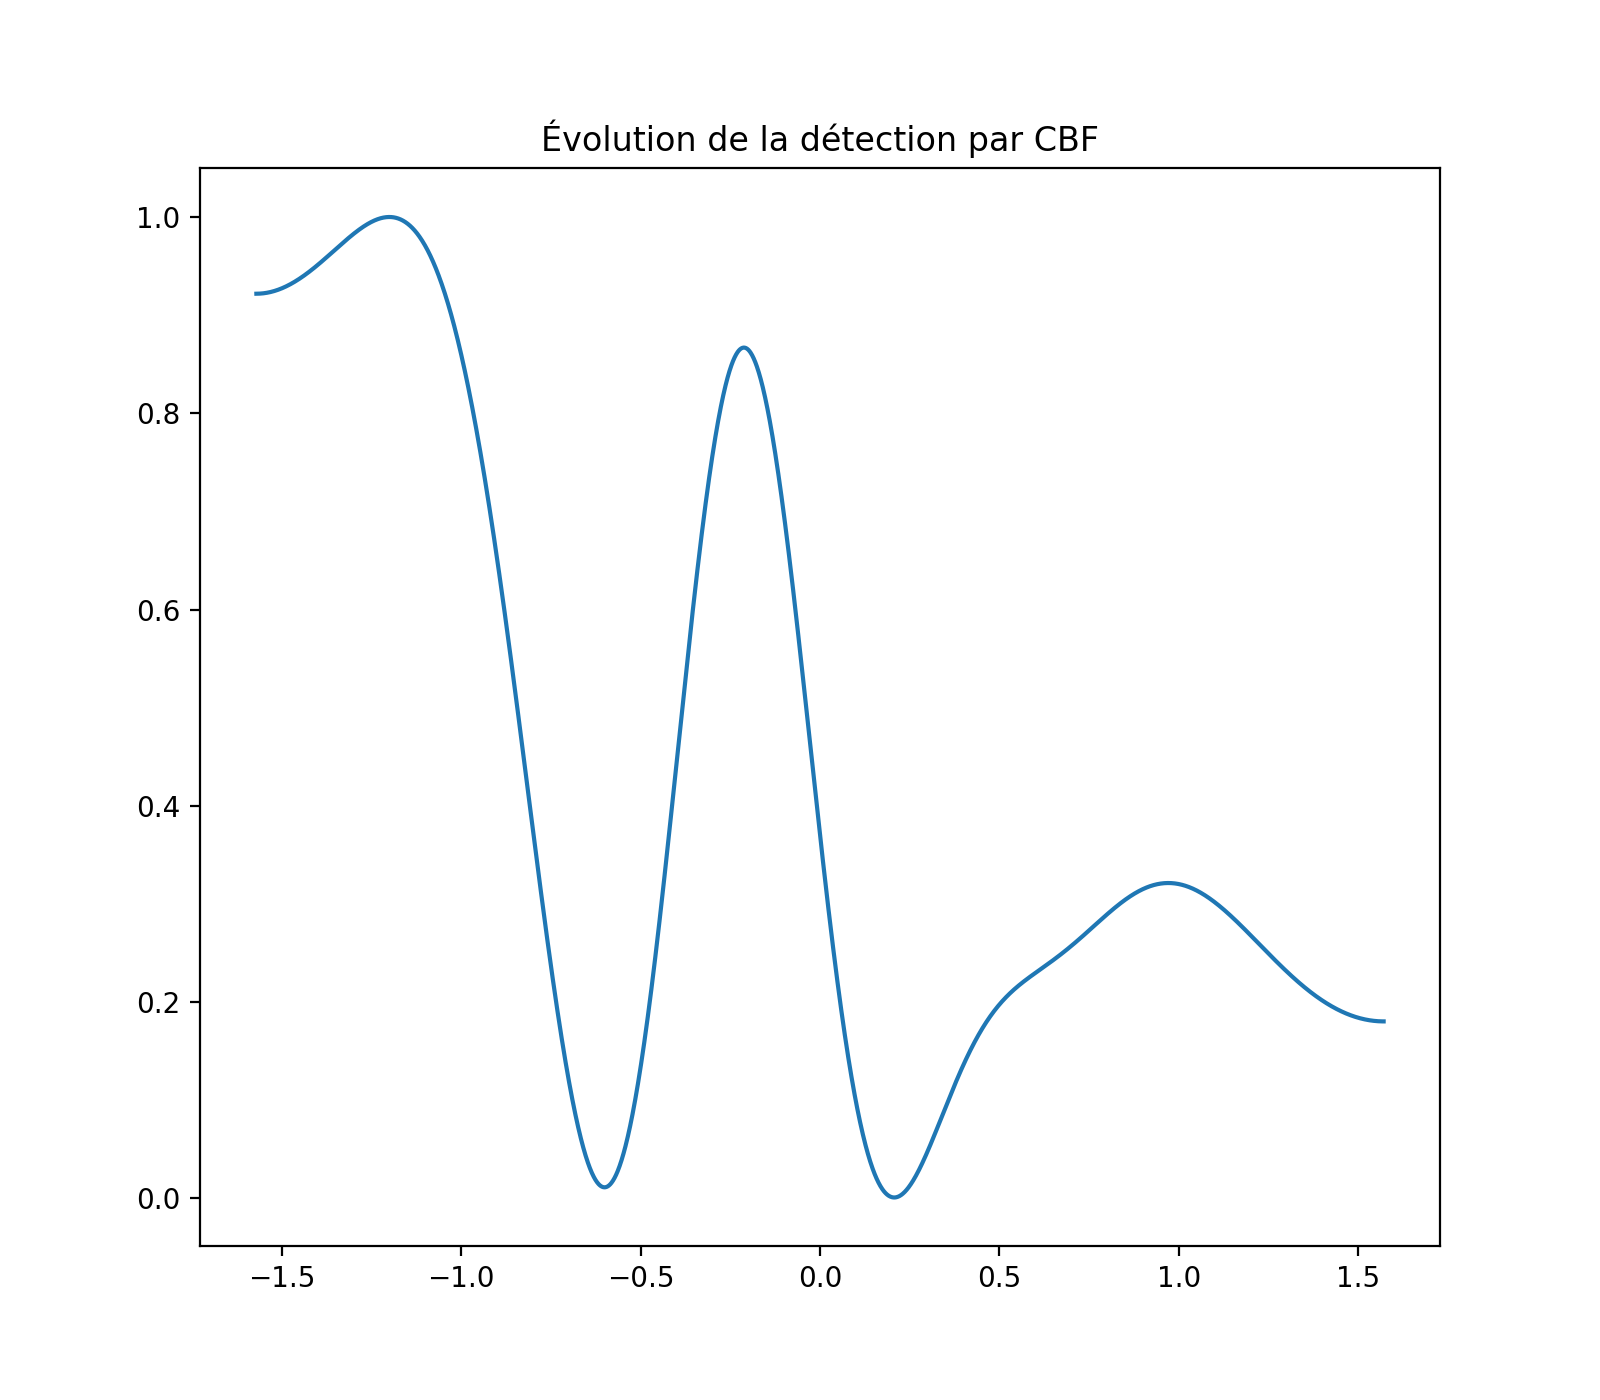

In [27]:
import matplotlib.animation as animation
fig, ax = plt.subplots(figsize=(8,7))
plt.xlabel
line, = ax.plot(angle, Mouv1[0])


def animate(i):
    line.set_ydata(Mouv1[i])  # update the data
    return line,

def init():
    line.set_ydata(np.ma.array(angle, mask=True))
    return line,

ani = animation.FuncAnimation(fig, animate, np.arange(1, 50), init_func=init,interval=100, blit=True)
plt.title("Évolution de la détection par CBF")
plt.show()

#### MUSIC


<IPython.core.display.Javascript object>


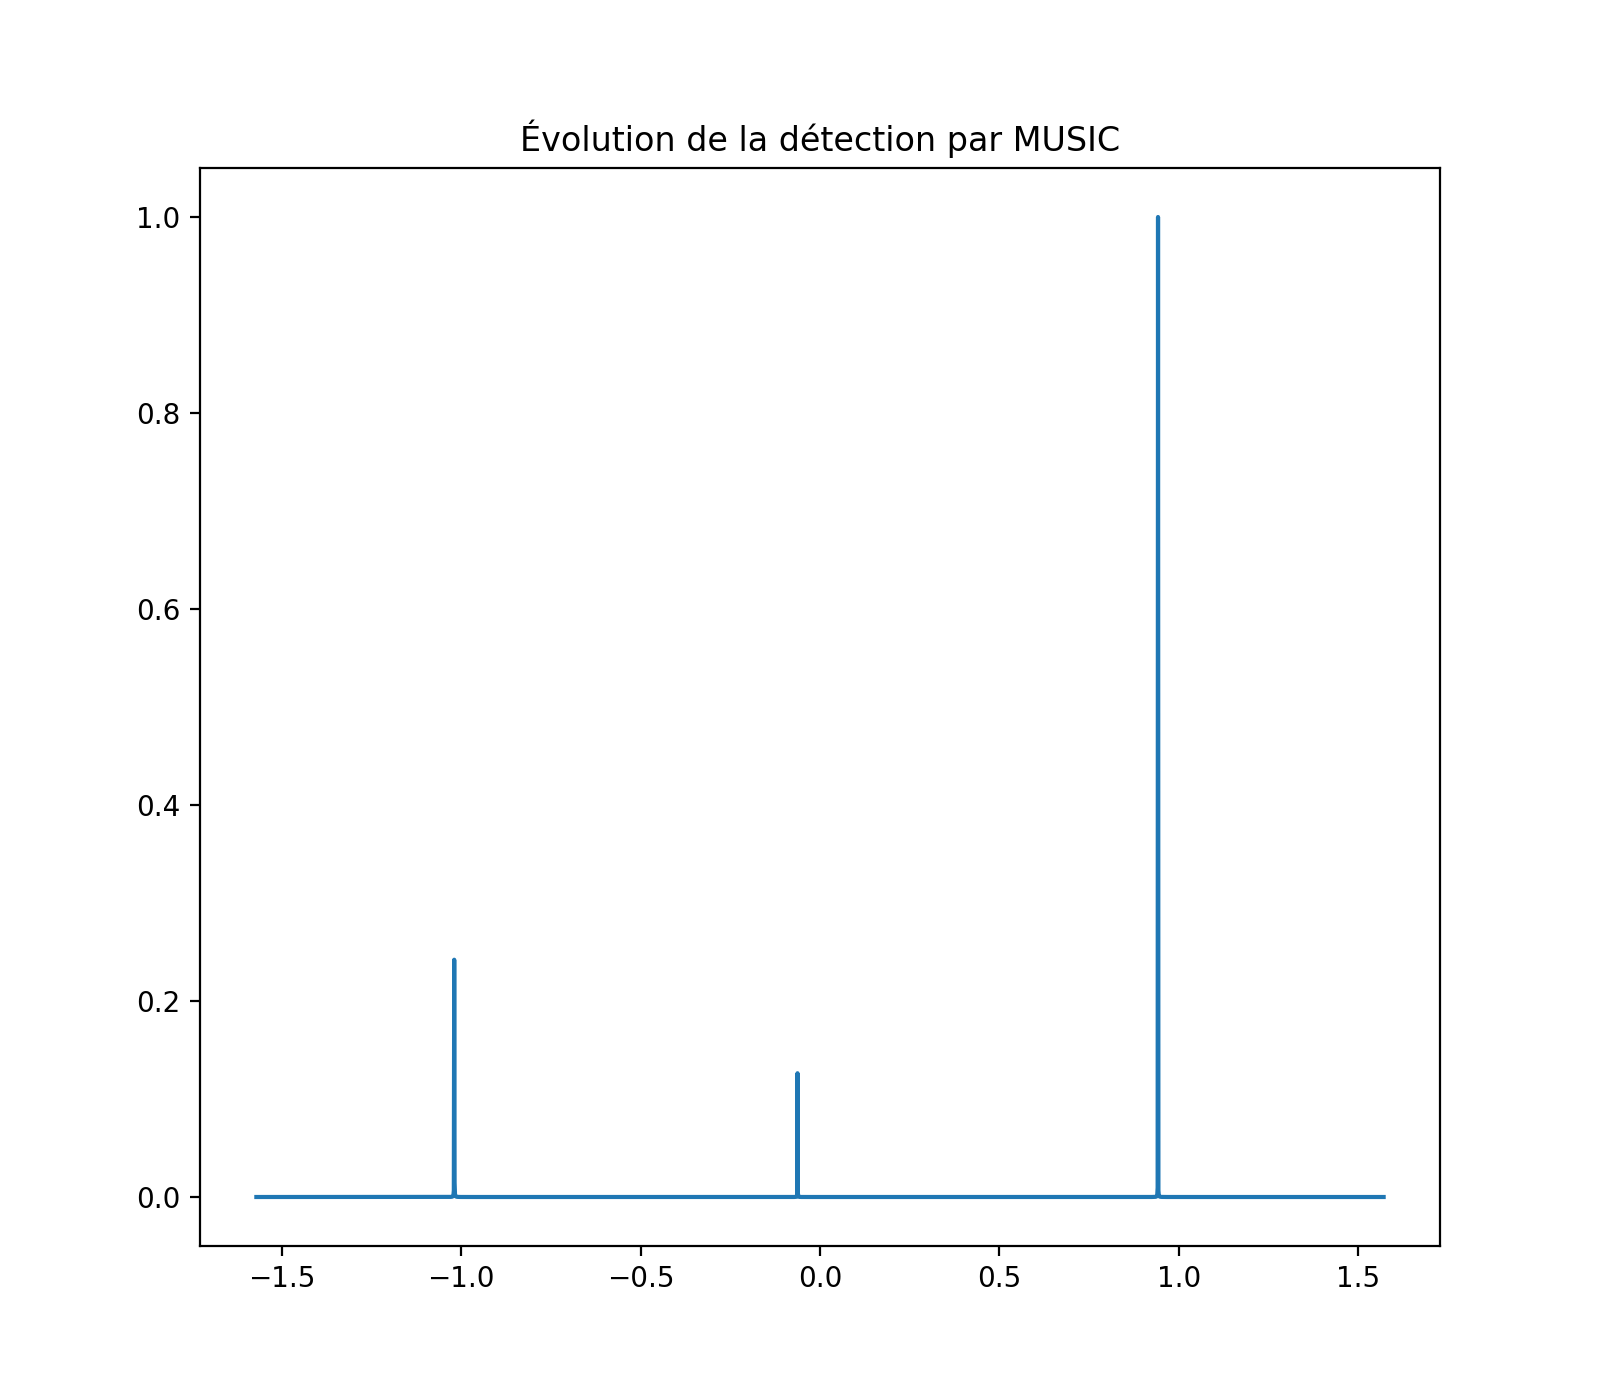

In [28]:
fig, ax = plt.subplots(figsize=(8,7))

line, = ax.plot(angle, Mouv2[0])


def animate(i):
    line.set_ydata(Mouv2[i])  
    return line,


def init():
    line.set_ydata(np.ma.array(angle, mask=True))
    return line,

ani = animation.FuncAnimation(fig, animate, np.arange(1, 50), init_func=init,interval=100, blit=True)
plt.title("Évolution de la détection par MUSIC")
plt.show()

#### MVDR

<IPython.core.display.Javascript object>


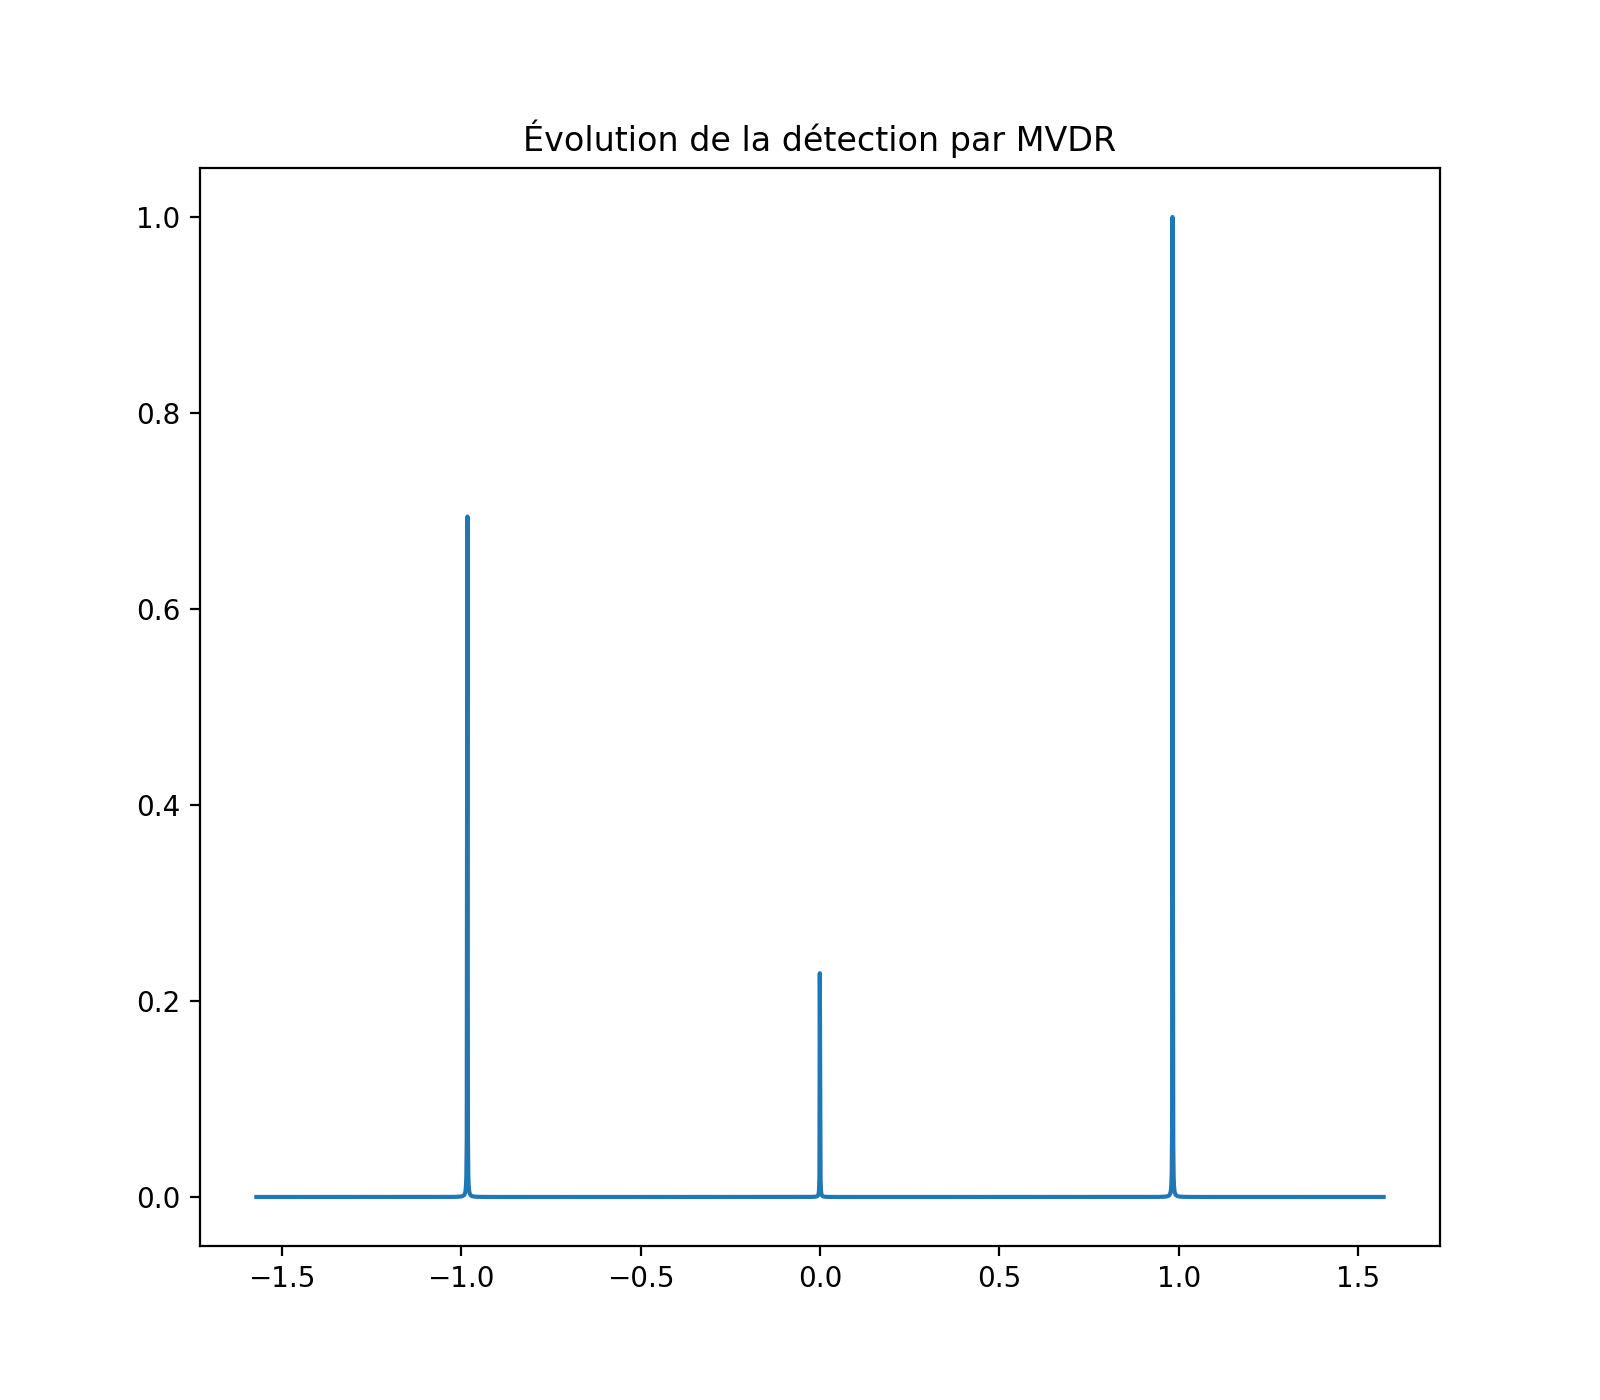

In [26]:
fig, ax = plt.subplots(figsize=(8,7))

line, = ax.plot(angle, Mouv3[0])


def animate(i):
    line.set_ydata(Mouv3[i])  # update the data
    return line,

def init():
    line.set_ydata(np.ma.array(angle, mask=True))
    return line,

ani = animation.FuncAnimation(fig, animate, np.arange(1, 50), init_func=init,interval=300, blit=True)
plt.title("Évolution de la détection par MVDR")
plt.show()

## Remarques quant à l'efficacité de l'estimation des directions

La détection se passe bien si les sources ne sont pas dans des directions très proches : Au début, les directions sont bien définies. Bien sur, lorsque les directions de deux (ou plus) RADAR sont les mêmes,il y a ambiguïté. Rappelons nous qu'on ne peut pas détecter plus de sources que l'on a de capteurs dans notre ULA. 